## Descrição

O presente projeto irá utilizar algoritmos de clusterização para agrupar filmes semelhantes em clusters, o que será feito a partir das descrições dos mesmos, que será pré-processada por meio de word embedding e técnicas de preprocessamento.

## Importando Bibliotecas

In [10]:
# Bibliotecas básicas de visualização e manipulação de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Processamento de Linguagem Natural
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import spacy
nlp = spacy.load("en_core_web_sm")

from nltk.stem import PorterStemmer

# Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

# Modelo de Clusterização
from sklearn.cluster import KMeans

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joaoc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Importando o kaagglehub para baixar o dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shivamb/netflix-shows")

print("Path to dataset files:", path)

c:\Users\joaoc\anaconda3\envs\projeto-nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\joaoc\.cache\kagglehub\datasets\shivamb\netflix-shows\versions\5


## Visualizando e analisando o dataset

In [12]:
df = pd.read_csv(path + "/netflix_titles.csv")
df.head(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
5,s6,TV Show,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",The arrival of a charismatic young priest brin...
6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,"September 24, 2021",2021,PG,91 min,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."
8,s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,"September 24, 2021",2021,TV-14,9 Seasons,"British TV Shows, Reality TV",A talented batch of amateur bakers face off in...
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...


In [13]:
# Tamanho do dataset
df.shape

(8807, 12)

In [14]:
# Criando um dataset apenas com as colunas relevantes para análise dos filmes.
df_movies = df[df["type"] == "Movie"].drop(['show_id', 'date_added', 'rating', 'duration', 'listed_in'], axis=1).reset_index(drop=True)
df_movies.head(10)

,type,title,director,cast,country,release_year,description
0,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2020,"As her father nears the end of his life, filmm..."
1,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,2021,Equestria's divided. But a bright-eyed hero be...
2,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...",1993,"On a photo shoot in Ghana, an American model s..."
3,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,2021,A woman adjusting to life after a loss contend...
4,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic",2021,After most of her family is murdered in a terr...
5,Movie,Confessions of an Invisible Girl,Bruno Garotti,"Klara Castanho, Lucca Picon, Júlia Gomes, Marc...",NaN,2021,When the clever but socially-awkward Tetê join...
6,Movie,Europe's Most Dangerous Man: Otto Skorzeny in ...,"Pedro de Echave García, Pablo Azorín Williams",NaN,NaN,2020,Declassified documents reveal the post-WWII li...
7,Movie,Intrusion,Adam Salky,"Freida Pinto, Logan Marshall-Green, Robert Joh...",NaN,2021,After a deadly home invasion at a couple’s new...
8,Movie,Avvai Shanmughi,K.S. Ravikumar,"Kamal Hassan, Meena, Gemini Ganesan, Heera Raj...",NaN,1996,Newly divorced and denied visitation rights wi...
9,Movie,Go! Go! Cory Carson: Chrissy Takes the Wheel,"Alex Woo, Stanley Moore","Maisie Benson, Paul Killam, Kerry Gudjohnsen, ...",NaN,2021,From arcade games to sled days and hiccup cure...


Text(0.5, 1.0, 'Top 10 years with most movie releases')

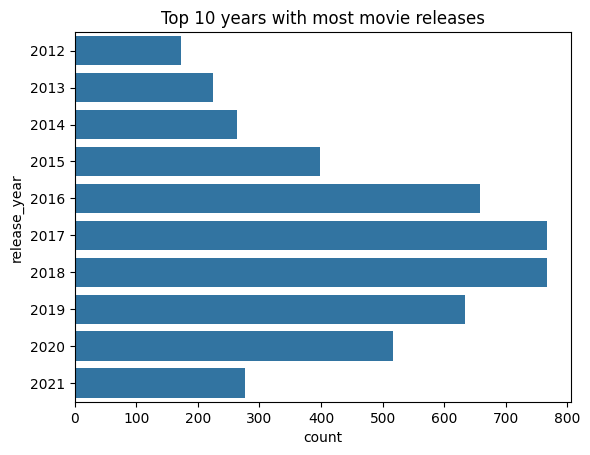

In [15]:
# Verificando os anos com mais lançamentos de filmes

top_years = df_movies[ 'release_year'].value_counts()[:10].sort_index()
sns.countplot(data=df_movies, y='release_year', order=top_years.index)

plt.title("Top 10 years with most movie releases")

In [16]:
# Verificando os diretores com mais filmes no catálogo

def separate_directors_in_director_column_in_dataframe(_df):
    df = _df[['director']]
    new_df = pd.DataFrame()

    for _, row in df.iterrows():
        directors = str(row['director']).split(", ")
        for director in directors:
            new_row = row.copy()
            new_row['director'] = director
            new_df = pd.concat([new_df, pd.DataFrame([new_row])], ignore_index=True)

    return new_df[new_df['director'] != 'nan']

df_movies_unique_line_directors = separate_directors_in_director_column_in_dataframe(df_movies)

Text(0.5, 1.0, 'Top 10 directors with most movie releases')

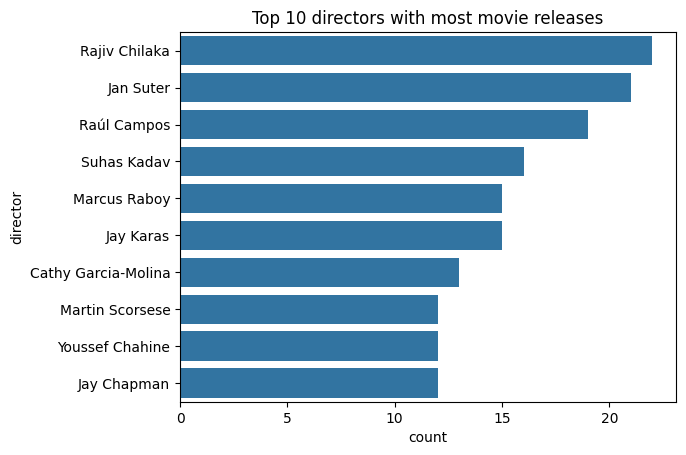

In [17]:
# Mostrando os diretores com mais filmes no catálogo

top_directors = df_movies_unique_line_directors['director'].value_counts()[:10]
sns.countplot(data=df_movies_unique_line_directors, y='director', order=top_directors.index)

plt.title("Top 10 directors with most movie releases")

## Pré-processamento das descrições dos filmes

In [18]:
# Salvando as stopwords em ingles
stop_words = set(stopwords.words('english'))

# Função para pré-processamento do texto
def preprocess_text(text):
    doc = nlp(text)

    tokens = [
        token.lemma_.lower() for token in doc
        if token.is_alpha and token.text.lower() not in stop_words
    ]

    return ' '.join(tokens)

In [19]:
# Aplicando o pré-processamento na coluna de descrição.

df_movies['processed_description'] = df_movies['description'].apply(preprocess_text)
df_movies.head(10)

,type,title,director,cast,country,release_year,description,processed_description
0,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2020,"As her father nears the end of his life, filmm...",father near end life filmmaker kirsten johnson...
1,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,2021,Equestria's divided. But a bright-eyed hero be...,equestria divided bright eyed hero believe ear...
2,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...",1993,"On a photo shoot in Ghana, an American model s...",photo shoot ghana american model slip back tim...
3,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,2021,A woman adjusting to life after a loss contend...,woman adjust life loss contend feisty bird tak...
4,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic",2021,After most of her family is murdered in a terr...,family murder terrorist bombing young woman un...
5,Movie,Confessions of an Invisible Girl,Bruno Garotti,"Klara Castanho, Lucca Picon, Júlia Gomes, Marc...",NaN,2021,When the clever but socially-awkward Tetê join...,clever socially awkward tetê join new school a...
6,Movie,Europe's Most Dangerous Man: Otto Skorzeny in ...,"Pedro de Echave García, Pablo Azorín Williams",NaN,NaN,2020,Declassified documents reveal the post-WWII li...,declassify document reveal post wwii life otto...
7,Movie,Intrusion,Adam Salky,"Freida Pinto, Logan Marshall-Green, Robert Joh...",NaN,2021,After a deadly home invasion at a couple’s new...,deadly home invasion couple new dream house tr...
8,Movie,Avvai Shanmughi,K.S. Ravikumar,"Kamal Hassan, Meena, Gemini Ganesan, Heera Raj...",NaN,1996,Newly divorced and denied visitation rights wi...,newly divorce deny visitation right daughter d...
9,Movie,Go! Go! Cory Carson: Chrissy Takes the Wheel,"Alex Woo, Stanley Moore","Maisie Benson, Paul Killam, Kerry Gudjohnsen, ...",NaN,2021,From arcade games to sled days and hiccup cure...,arcade game sle day hiccup cure cory carson cu...


In [20]:
# Criando a matriz de Bag of Words
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_movies['processed_description'])
X_array = X.toarray()
print(type(X_array))

<class 'numpy.ndarray'>


## Configuração e Aplicação do modelo de Clusterização

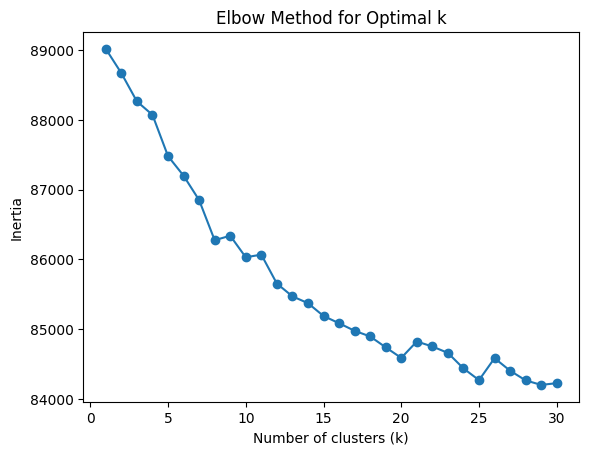

In [21]:
# Usando o método do cotovelo para encontrar o número ideal de clusters
inertias = []
for i in range(1, 31):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_array)
    inertias.append(kmeans.inertia_)


# Plotando o gráfico do método do cotovelo
plt.plot(range(1, 31), inertias, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.show()

Escolheremos o último ponto em que a inécia deixa de decrescer  de forma susbstancial (n=25)


In [22]:
# Escolhe-se k = 25
n_clusters = 25

# Inicialização do modelo
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_array)

# Adicionando os rótulos dos clusters ao DataFrame original
df_movies['cluster'] = kmeans.labels_

## Visualização e Análise dos Resultados

In [23]:
# Contagem dos clusters
category_counts = df_movies['cluster'].value_counts()

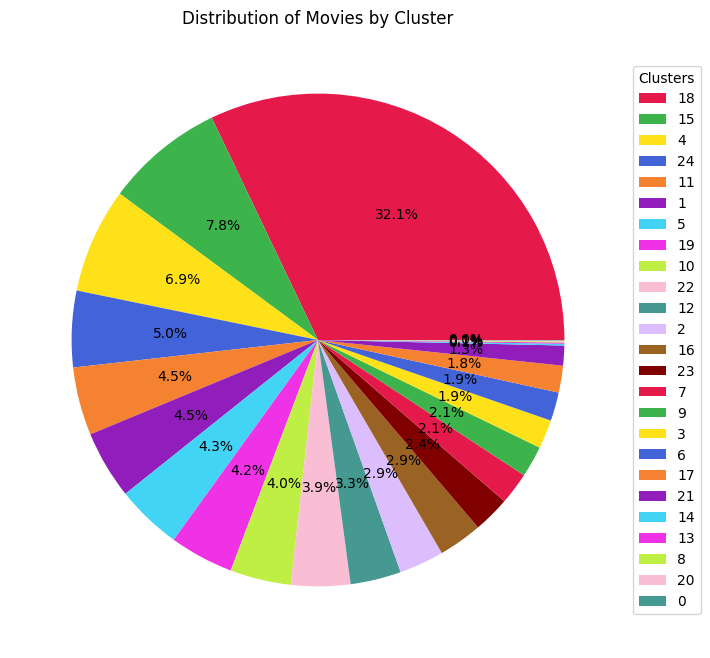

In [24]:
# Creating a pie chart of the clusters amounts

colors = [
    '#E6194B', '#3CB44B', '#FFE119', '#4363D8', '#F58231', '#911EBB', '#42D4F4', '#F032E6', '#BFEF45', '#FABED4', '#469990', '#DCBEFF', '#9A6324', '#800000'
]


# Plotando o gráfico de pizza dos clusters
plt.figure(figsize=(8,8))
plt.pie(category_counts, autopct='%1.1f%%', colors=sns.color_palette(colors)[0:len(category_counts)])
plt.legend(title="Clusters", labels=category_counts.index, bbox_to_anchor=(1, 0.5), loc='center left')
plt.title("Distribution of Movies by Cluster")
plt.show()

In [25]:
# Criando a coluna de common_words no DataFrame
df_movies['common_words'] = pd.Series(dtype=str)

# Obtendo o nome das palavras relacionada a cada coluna no vetor de Bag of Words
feature_names = vectorizer.get_feature_names_out()


for i in range(n_clusters):
    cluster_indexes = df_movies[df_movies['cluster'] == i].index.to_numpy()

    words_of_cluster = X_array[cluster_indexes]

    # Encontrando os indices em que as palavras são comuns a todos os filmes do cluster
    common_words = words_of_cluster[0]
    for j in range(1, words_of_cluster.shape[0]):
        common_words = np.logical_and(common_words, words_of_cluster[j])

    for index in cluster_indexes:
        words_as_strings = str(feature_names[np.where(common_words==True)[0]])
        df_movies.loc[index, 'common_words'] = words_as_strings

In [26]:
# Visualizando os filmes por cluster, para tentar identifcar os gêneros.
custom_dataframe = df_movies[df_movies['cluster'] == 0][['title', 'description', 'cluster', 'common_words']].head(5)

for i in range(1, 25):
    custom_dataframe = pd.concat([custom_dataframe, df_movies[df_movies['cluster'] == i][['title', 'description', 'cluster', 'common_words']].head(5)], ignore_index=True)

custom_dataframe.head(10)


,title,description,cluster,common_words
0,American Factory,"In this documentary, hopes soar when a Chinese...",0,['american' 'company' 'dream']
1,Center Stage,Vying for a spot in the American Ballet Compan...,0,['american' 'company' 'dream']
2,Omo Ghetto: the Saga,Twins are reunited as a good-hearted female ga...,1,['take']
3,Anjaam,A wealthy industrialist’s dangerous obsession ...,1,['take']
4,In Too Deep,Rookie cop Jeffrey Cole poses as a drug dealer...,1,['take']
5,Initial D,"By day, an 18-year-old delivers tofu for his f...",1,['take']
6,The Nutty Professor,"After being made fun of for his weight, a kind...",1,['take']
7,InuYasha the Movie: Affections Touching Across...,A powerful demon has been sealed away for 200 ...,2,['world']
8,JJ+E,"Elisabeth and John-John live in the same city,...",2,['world']
9,Rhyme & Reason,The world and culture of rap song topics such ...,2,['world']


A partir da visualização a cima, vê-se que após a clusterização, formam-se agrupamentos que são formados a partir de palavras que não dizem nada sobre o gênero do filme (o que se confirma pela leitura das descrições), portanto, faz-se necessário olhar as palavras comuns de cada cluster e utilizar o senso crítico para dizer que realmente formou-se um agrupamento por gênero.

In [27]:
for cluster in range(n_clusters):
    common_words = df_movies[df_movies['cluster'] == cluster]['common_words'].values[0]
    print(f"Cluster {cluster} com palavras em comum {common_words}:")

Cluster 0 com palavras em comum ['american' 'company' 'dream']:
Cluster 1 com palavras em comum ['take']:
Cluster 2 com palavras em comum ['world']:
Cluster 3 com palavras em comum ['follow']:
Cluster 4 com palavras em comum ['find']:
Cluster 5 com palavras em comum ['young']:
Cluster 6 com palavras em comum ['force']:
Cluster 7 com palavras em comum []:
Cluster 8 com palavras em comum ['murder']:
Cluster 9 com palavras em comum ['boy']:
Cluster 10 com palavras em comum ['woman']:
Cluster 11 com palavras em comum ['family']:
Cluster 12 com palavras em comum ['two']:
Cluster 13 com palavras em comum []:
Cluster 14 com palavras em comum ['home']:
Cluster 15 com palavras em comum ['life']:
Cluster 16 com palavras em comum ['get']:
Cluster 17 com palavras em comum ['murder']:
Cluster 18 com palavras em comum []:
Cluster 19 com palavras em comum ['man']:
Cluster 20 com palavras em comum ['abandon' 'activity' 'alarm' 'eager' 'eerie' 'event' 'group' 'lush' 'may'
 'paranormal' 'property' 'rede

Observamos que é possível encontrar palavras que denunciam gêneros, por exemplo: 'murder', 'documentary' e 'death'e também vê-se o cluster 20, com muitas palavras em comum. Portanto faz-se necessário visualizar esses específicos para fazer julgamentos.

In [28]:
# Visualizando os filmes por cluster, para tentar identifcar os gêneros.

custom_dataframe = df_movies[df_movies['cluster'] == 8][['title', 'description', 'cluster', 'common_words']].head(3)

for i in [17, 20, 21, 22]:
    custom_dataframe = pd.concat([custom_dataframe, df_movies[df_movies['cluster'] == i][['title', 'description', 'cluster', 'common_words']].head(3)], ignore_index=True)

custom_dataframe


,title,description,cluster,common_words
0,Ije: The Journey,When her sister is accused of multiple murders...,8,['murder']
1,The Yin-Yang Master: Dream Of Eternity,"When a demonic serpent reawakens, the Yin-Yang...",8,['murder']
2,Uncovered,"To solve her sister's murder, a corporate prot...",8,['murder']
3,Clear and Present Danger,"When the president's friend is murdered, CIA D...",17,['murder']
4,Wind River,A tracker with the U.S. Fish and Wildlife Serv...,17,['murder']
5,Kucch To Hai,A student tries to steal a test from a teacher...,17,['murder']
6,Boomika,"Paranormal activity at a lush, abandoned prope...",20,['abandon' 'activity' 'alarm' 'eager' 'eerie' ...
7,Boomika (Hindi),"Paranormal activity at a lush, abandoned prope...",20,['abandon' 'activity' 'alarm' 'eager' 'eerie' ...
8,Boomika (Malayalam),"Paranormal activity at a lush, abandoned prope...",20,['abandon' 'activity' 'alarm' 'eager' 'eerie' ...
9,Dick Johnson Is Dead,"As her father nears the end of his life, filmm...",21,['death']


Verificamos que os filmes do cluster 20 (O que possui muitas palavras em comum) são o mesmo filme em diferentes línguas, e que é possível apenas colocar como mesmo gênero os filmes do cluster 8 (morte) e do cluster 22 (documentary).

## Conclusão

É uma tarefa difícil classificar filmes no mesmo gênero baseado nas palavras, considerando que de fato, pode-se aparecer essa relação a partir de palavras em comum, porém existem palavras que não denunciam gêneros e agrupam filmes, assim como, existem filmes do mesmo gênero com palavras com mesmo teor semântico, ex: death, murder, o que necessitaria modelos mais complexos.